## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

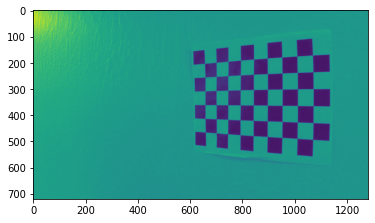

In [1]:
import numpy as np
import cv2
import glob
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [2]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

In [3]:
# images = glob.glob('./test_images/*.jpg')
images = [cv2.imread(file) for file in glob.glob("./test_images/*.jpg")]

In [4]:
def showImages(images):
    fig, axes = plt.subplots(4, 2, figsize=(15, 15))
    indexes = range(8)
    for ax, image in zip(axes.flat, images):
        ax.imshow(image, cmap='gray')
        ax.axis('off')
showImages(images)

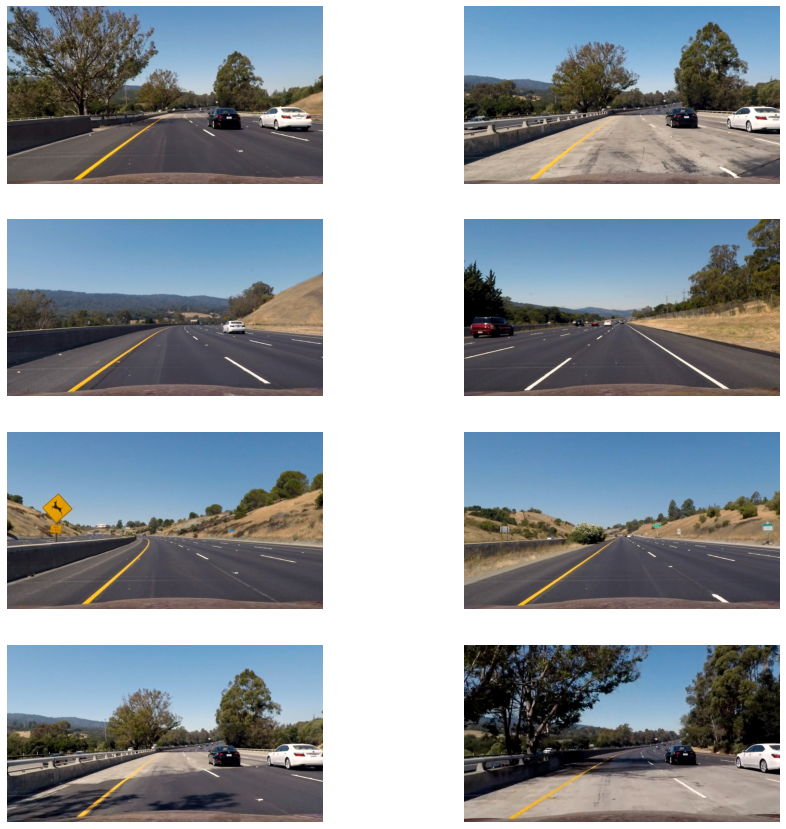

In [5]:
def undistort(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
undist_images = []
for image in images:
    undist_images.append(undistort(image))
showImages(undist_images)

In [6]:
def sChannel(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    hls_binary_output = np.zeros_like(s_channel)
    hls_binary_output[(s_channel > 90) & (s_channel <= 255)] = 1
    return hls_binary_output
sChannel_images = []
for image in images:
    undist = undistort(image)
    sChannel_images.append(sChannel(undist))
showImages(sChannel_images)

In [7]:
def Sobel(image):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= 30) & (gradmag <= 100)] = 1
    return binary_output
sobel_images = []
for image in images:
    undist = undistort(image)
    sobel_images.append(Sobel(undist))
showImages(sobel_images)

In [8]:
def Combined(image):
    sChannel_image = sChannel(image)
    sobel_image = Sobel(image)
    color_binary = np.dstack(( np.zeros_like(sobel_image), sobel_image, sChannel_image)) * 255
    combined_binary = np.zeros_like(sobel_image)
    combined_binary[(sobel_image == 1) | (sChannel_image == 1)] = 1
    return combined_binary
combined_images = []
for image in images:
    undist = undistort(image)
    combined_images.append(Combined(undist))
showImages(combined_images)

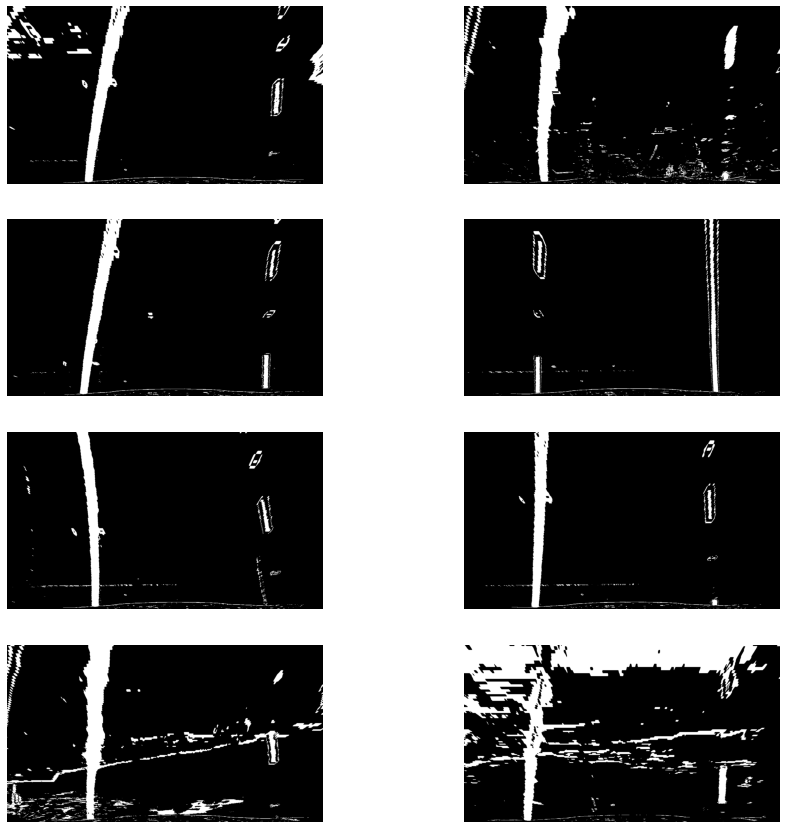

In [9]:
def PerspectiveTransform(image):
    img_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped
warped_images = []
src = np.float32([[  100.,   719.],
                      [  542.,   470.],
                      [  738.,   470.],
                      [ 1180.,   719.]])
dst = np.float32([[ 200.,  720.],
                      [ 200.,    0.],
                      [ 1080.,    0.],
                      [ 1080.,  720.]])
for image in images:
    undist = undistort(image)
    warped = PerspectiveTransform(Combined(undist))
    warped_images.append(warped)
showImages(warped_images)

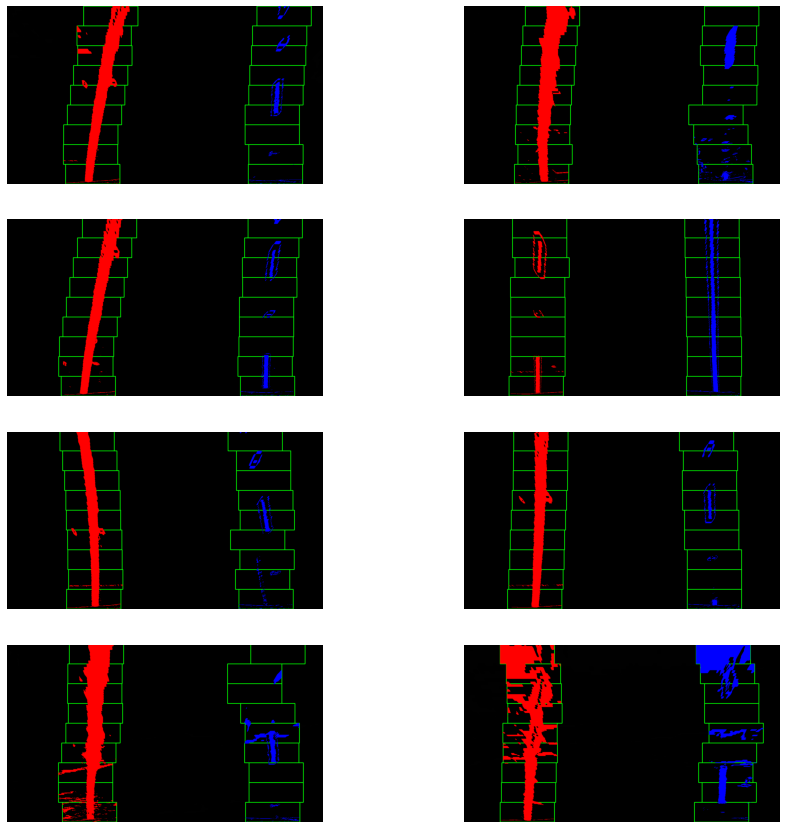

In [10]:
def findLanes(warped, nwindows=9, margin=110, minpix=50):
    bottom_half = warped[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    out_img = np.dstack((warped, warped, warped))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    window_height = np.int(warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
       
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
      
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
  
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return (out_img, left_fit, right_fit, leftx, lefty, rightx, righty, nonzerox, nonzeroy)

lane_images = []
for warped in warped_images:
    out_img, left_fit, right_fit, leftx, lefty, rightx, righty, nonzerox, nonzeroy = findLanes(warped)
    lane_images.append(out_img)
showImages(lane_images)

In [11]:
def Curvature(warped):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    out_img, left_fit, right_fit, leftx, lefty, rightx, righty, nonzerox, nonzeroy = findLanes(warped)
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad/1000, right_curverad/1000, left_fit, right_fit, leftx, lefty, rightx, righty

for warped in warped_images:
    left_radius, right_radius, left_fit, right_fit, leftx, lefty, rightx, righty = Curvature(warped)
    print('Left : {:.2f} km, Right : {:.2f} km'.format(left_radius, right_radius))

Left : 27.65 km, Right : 82.19 km
Left : 8.96 km, Right : 11.89 km
Left : 2.10 km, Right : 1.69 km
Left : 3.59 km, Right : 25.42 km
Left : 2.34 km, Right : 0.60 km
Left : 3.19 km, Right : 1.40 km
Left : 1.51 km, Right : 0.35 km
Left : 1.02 km, Right : 7.64 km


In [12]:
def drawLane(warped, img):
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    out_img, left_fit, right_fit, leftx, lefty, rightx, righty, nonzerox, nonzeroy = findLanes(warped)
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    result = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
    return result

result_images = []
for i in range(8):
    result_images.append(drawLane(warped_images[i], images[i]))
showImages(result_images)

In [13]:
from moviepy.editor import VideoFileClip

class Lane():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.left_fit_m = None
        self.right_fit_m = None
        self.leftCurvature = None
        self.rightCurvature = None

def calculateLanes(img):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    undist = undistort(img)
    warped = PerspectiveTransform(Combined(undist))
    leftCurvature, rightCurvature, left_fit, right_fit, leftx, lefty, rightx, righty = Curvature(warped)
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle)

def displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle):
    undist = undistort(img)
    warped = PerspectiveTransform(Combined(undist))
    output = drawLane(warped, img)
    
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} km'.format(leftCurvature), (50, 50), font, 1, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} km'.format(rightCurvature), (50, 120), font, 1, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, 1, fontColor, 2)
    return output

def videoPipeline(inputVideo, outputVideo):
    myclip = VideoFileClip(inputVideo)
    
    leftLane = Lane()
    rightLane = Lane()
    
    def processImage(img):
        left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle = calculateLanes(img)
        if leftCurvature > 10000:
            left_fit = leftLane.left_fit
            left_fit_m = leftLane.left_fit_m
            leftCurvature = leftLane.leftCurvature
        else:
            leftLane.left_fit = left_fit
            leftLane.left_fit_m = left_fit_m
            leftLane.leftCurvature = leftCurvature
        
        if rightCurvature > 10000:
            right_fit = rightLane.right_fit
            right_fit_m = rightLane.right_fit_m
            rightCurvature = rightLane.rightCurvature
        else:
            rightLane.right_fit = right_fit
            rightLane.right_fit_m = right_fit_m
            rightLane.rightCurvature = rightCurvature
            
        return displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle)

    clip = myclip.fl_image(processImage)
    clip.write_videofile(outputVideo, audio=False)
    
# Project video
videoPipeline('project_video.mp4', 'video_output/project_video.mp4')

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video video_output/project_video.mp4.
Moviepy - Writing video video_output/project_video.mp4



Moviepy - Done !
Moviepy - video ready video_output/project_video.mp4
